# Alignment of genes expression and lipids expression images

First of all, import all the dependencies that are needed for the notebook to work.

Some dependencies that might be less easy to import are the ones related to STalign. In particular:
 
go to https://github.com/JEFworks-Lab/STalign and follow the instructions inside the README; otherwise, simply run:
 
                            pip install --upgrade "git+https://github.com/JEFworks-Lab/STalign.git"
from terminal.

In [1]:
from STalign import STalign
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
#%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd # for csv.
from matplotlib import cm
from matplotlib.lines import Line2D
import os
from os.path import exists,split,join,splitext
from os import makedirs
import glob
import requests
from collections import defaultdict
import nrrd
import torch
from torch.nn.functional import grid_sample
import tornado
import copy
import skimage
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.ndimage import rotate
import pandas as pd


Bad key text.latex.preview in file /Users/davideserra/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /Users/davideserra/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /Users/davideserra/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpe

## Paths
Write here once and for all the paths to the two images you want to align

In [4]:
path_genes = 'Genes/embryo_genes_df.pkl'
path_lipids = 'Lipids/embryo_lipids_df.pkl'

In [5]:
genes = pd.read_pickle(path_genes)
lipids = pd.read_pickle(path_lipids)

Create a dataframe with the intensity of each gene and normalize the values

In [6]:
genes['intensity'] = genes.iloc[:, :-2].sum(axis=1)
genes = genes[['x', 'y', 'intensity']]
genes['intensity'] = genes['intensity'] / genes['intensity'].max()
print(genes.head())
print(genes.shape)


     x   y  intensity
0  171  16   0.210526
1  172  16   0.000000
2  173  16   0.000000
3  174  16   0.052632
4  142  17   0.000000
(41067, 3)


In [7]:
# Limits of the coordinates
max_x = genes['x'].max()
max_y = genes['y'].max()

# Array with intensities for each coordinate
GENES = np.zeros((max_y + 1, max_x + 1))
for idx, row in genes.iterrows():
    x, y, intensità = row['x'], row['y'], row['intensity']
    GENES[y.astype(int), x.astype(int)] = intensità

Create a dataframe with the intensity of each lipid and normalize the values

In [8]:
lipids['intensity'] = lipids.iloc[:, :-3].sum(axis=1)
lipids = lipids[['x', 'y', 'intensity']]
lipids['intensity'] = lipids['intensity'] / lipids['intensity'].max()
print(lipids.head())
print(lipids.shape)

     x   y  intensity
0  305  24   0.494900
1  306  24   0.609921
2  307  24   0.606266
3  308  24   0.679798
4  309  24   0.494344
(45187, 3)


In [9]:
# Limits of the coordinates
max_x = lipids['x'].max()
max_y = lipids['y'].max()

# Array with intensities for each coordinate
LIPIDS = np.zeros((max_y + 1, max_x + 1))
for idx, row in lipids.iterrows():
    x, y, intensità = row['x'], row['y'], row['intensity']
    LIPIDS[y.astype(int), x.astype(int)] = intensità

Plot genes and lipids images

Text(0.5, 1.0, 'Lipids intensity')

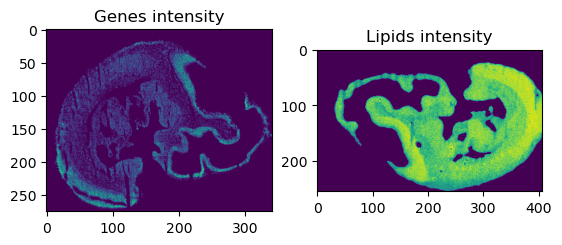

In [10]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(GENES)
ax[0].set_title('Genes intensity')

ax[1].imshow(LIPIDS)
ax[1].set_title('Lipids intensity')

If needed, rotate one of the images to make them aligned

Text(0.5, 1.0, 'Lipids intensity')

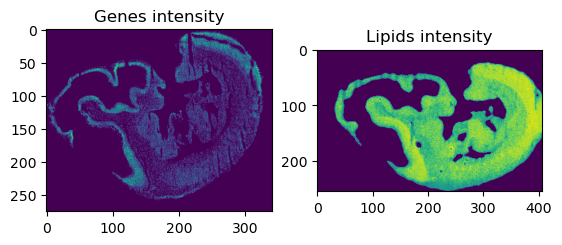

In [11]:
# rotation angle in degrees
theta_deg = 180

fig,ax = plt.subplots(1,2)
ax[0].imshow(rotate(GENES, angle=theta_deg))
ax[0].set_title('Genes intensity')

ax[1].imshow(LIPIDS)
ax[1].set_title('Lipids intensity')

Create a grid of coordinates for the genes and lipids images

In [12]:
dxA = np.array([50., 50.])
nxA = GENES.shape
# print(nxA)
xA = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nxA,dxA)]

dxB = np.array([50., 50.])
nxB = LIPIDS.shape
# print(nxB)
xB = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nxB,dxB)]

Here you can see a histogram with the intensities of the different pixels. You need it in order to set some parameters below

Text(0, 0.5, 'Number of Pixels')

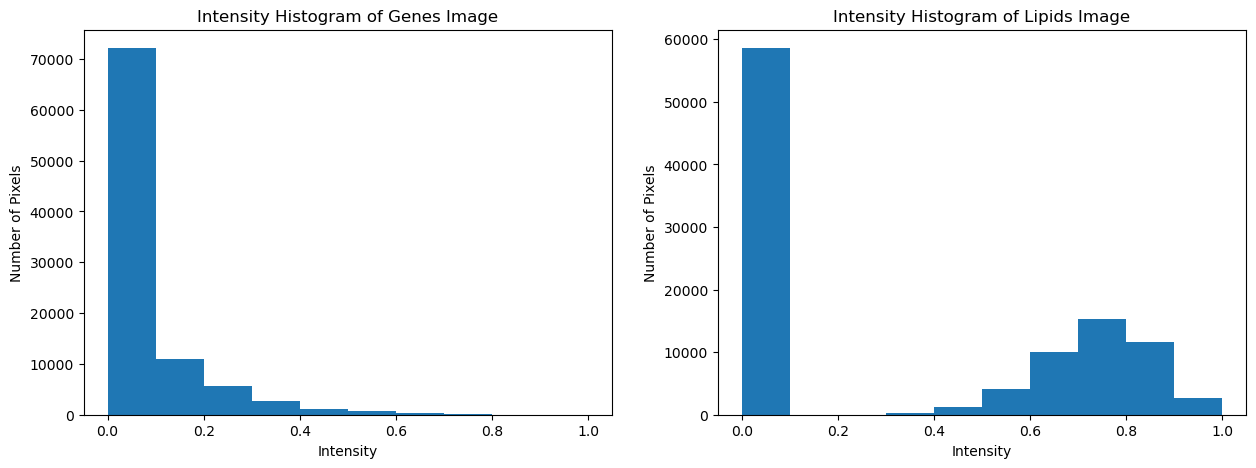

In [13]:
fig,ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].hist(GENES.ravel())
ax[0].set_title('Intensity Histogram of Genes Image')
ax[0].set_xlabel('Intensity')
ax[0].set_ylabel('Number of Pixels')
ax[1].hist(LIPIDS.ravel())
ax[1].set_title('Intensity Histogram of Lipids Image')
ax[1].set_xlabel('Intensity')
ax[1].set_ylabel('Number of Pixels')

Set the right scale to make the initial guess of the two images the most similar possible

# Suggestion:
Usually, to check if the scale_x and scale_y are selected correctly, I first run the main function STalign.LDDMM below with 'niter' = 1, so that you can have a fast output that shows you which are the initial guesses

In [14]:
scale_x = 0.9 #default = 0.9
scale_y = 1.1 #default = 0.9
theta0 = (np.pi/180)*-theta_deg

#T = np.array([1,30])

scale_atlas = np.array([[scale_x,0],
               [0,scale_y]])

L = np.array([[np.cos(theta0),-np.sin(theta0)],
              [np.sin(theta0),np.cos(theta0)]])
L = np.matmul(L,scale_atlas)#np.identity(3)


In [15]:
GENES_J = GENES[None]
LIPIDS_I = LIPIDS[None]

## MAIN FUNCTION
STalign.LDDMM(xA,GENES_J,xB,LIPIDS_I,**params):
it basically transforms the set of coordinates xA in the set of coordinates xB (so basically the output will be in the same coordinate framework of LIPIDS_I, the lipid image), interpolating the values of GENES_J, the gene expression's values.
Note that since STalign works with densities and not with points, you will have as output a matrix of density of the gene expression with same coordinates of the lipids image.

/Users/davideserra/opt/anaconda3/lib/python3.9/site-packages/STalign/STalign.py:1053: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T = torch.tensor(T,device=device,dtype=dtype,requires_grad=True)
/Users/davideserra/opt/anaconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
  0%|          | 0/600 [00:00<?, ?it/s]/Users/davideserra/opt/anaconda3/lib/python3.9/site-packages/STalign/STalign.py:1333: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axE[2].set_yscale('log')
100%|██████████| 600/600 [01:52<00:00,  5.35it/s

CPU times: user 2min 3s, sys: 45.5 s, total: 2min 48s
Wall time: 1min 52s


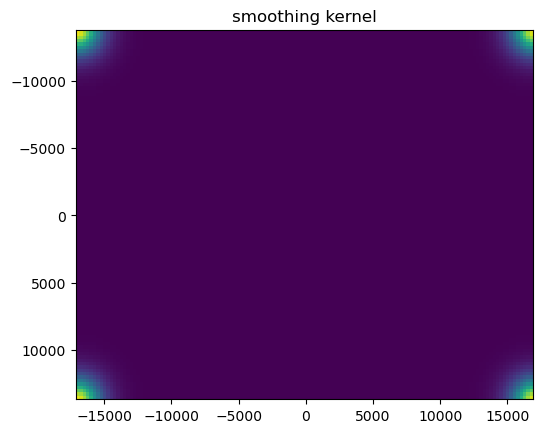

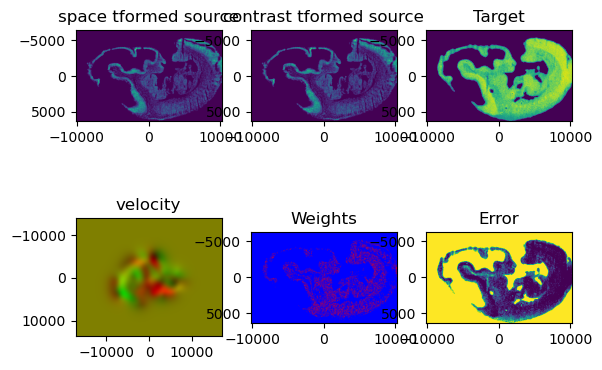

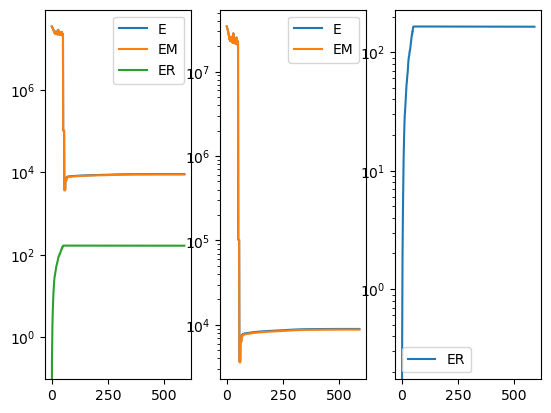

In [16]:
%%time
# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

# keep all other parameters default
params = {
            'niter': 600,
            'device':device,
            'epV': 50,
            'nt' : 10,
            'sigmaM' : 0.01,
            'L' : L,
            #'T' : T,
            'sigmaR' : 1000000,
            # 'epL' : 2e-8,
            # 'epT' : 2e-1,
            'a' : 500
          }

out = STalign.LDDMM(xA,GENES_J,xB,LIPIDS_I,**params)

# We can try to set a high sigma_matching in order to force the matchinh between the images rather than regularizing the alignment

## How to analyze the output
If the parmeters were set well, and the alignment at least tried to work, you should see the orange curve in the middle (representing the evolution of the matching error as the iterations grow) with a decreasing trend. In order for the alignment to reach the best possible result, the orange curve must have reached a plateau, so it should not be still decreasing in the last iterations. If it is:
- increase the number of niter;
- increase 'epV', which is the velocity gradient step.

If the orange curve is INCREASING, then you set the wrong parameters: start changing sigmaM of some orders of magnitude (0.1, then 1, then 10 and so on).

For the purpose of this specific goal, the best way to check the output is simply to plot the superimposition of the two images with the script you find below.

In [17]:
A = out['A']
v = out['v']
xv = out['xv']
Xs = out['Xs']
AI = out['AI']
E_out = out['E_out']

In [18]:
AI = STalign.interp(xA,GENES_J,Xs.permute(2,0,1))

Here you can see the superimposition of the two final images, that is, genes_transformed and lipids

Text(0.5, 1.0, 'Overlayed')

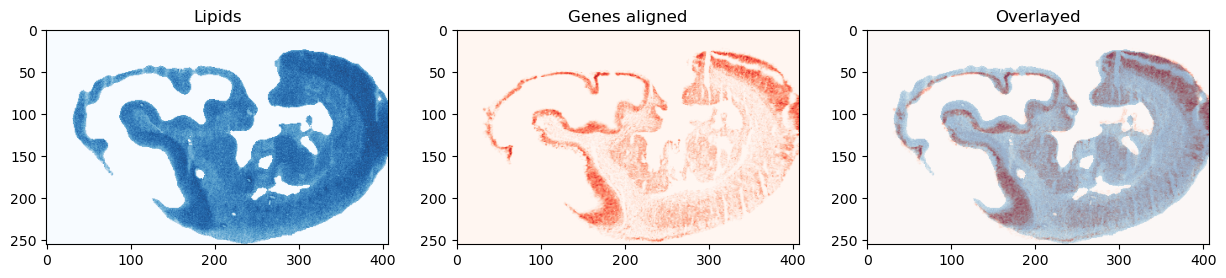

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mpl
import matplotlib.cm as cm
Ishow_target = LIPIDS
Ishow_target = Ishow_target.squeeze()
fig,ax = plt.subplots(1,3, figsize=(15,5))
ax0 = ax[0].imshow(Ishow_target, cmap = mpl.cm.Blues,alpha=0.9)
ax[0].set_title('Lipids')

ax1 = ax[1].imshow(   ((AI-torch.amin(AI,(1,2))[...,None,None])/(torch.amax(AI,(1,2))-torch.amin(AI,(1,2)))[...,None,None]).permute(1,2,0)[:,:,0].clone().detach().cpu(), cmap = mpl.cm.Reds,alpha=0.9)
ax1 = ax[1].set_title('Genes aligned')

ax2 = ax[2].imshow(   ((AI-torch.amin(AI,(1,2))[...,None,None])/(torch.amax(AI,(1,2))-torch.amin(AI,(1,2)))[...,None,None]).permute(1,2,0)[:,:,0].clone().detach().cpu(), cmap = mpl.cm.Reds,alpha=0.9)
ax2 = ax[2].imshow(Ishow_target, cmap = mpl.cm.Blues,alpha=0.4)
ax[2].set_title('Overlayed')


# Final dataframe

Here we construct the final dataframe, so that for each coordinate we have both the genes and lipids expression

In [68]:
genes = pd.read_pickle(path_genes)
for i in range(0, genes.shape[1]-2):
    genes = pd.read_pickle(path_genes)
    colonna = genes.columns[i]
    gene = genes.iloc[:, i]
    coords = genes.iloc[:, -2:]
    genes = pd.concat([gene, coords], axis=1)

    # Determina i limiti delle coordinate x e y
    max_x = genes['x'].max()
    max_y = genes['y'].max()

    # Inizializza un array bidimensionale con zeri
    GENES = np.zeros((max_y + 1, max_x + 1))

    # Popola l'array con i valori di intensità
    for idx, row in genes.iterrows():
        x, y, intensità = row['x'], row['y'], row[colonna]
        GENES[y.astype(int), x.astype(int)] = intensità

    GENES = GENES[None]

    final = STalign.interp(xA,GENES,Xs.permute(2,0,1))

    final = final[0]

    data = []
    for x in range(0, final.shape[0]):
        for y in range(0, final.shape[1]):
            intensity = final[x, y].item()
            data.append([x, y, intensity])

    df_gene = pd.DataFrame(data, columns=['x', 'y', colonna])
    if i == 0:
        df_final = df_gene
    if i != 0:
        df_final = pd.concat([df_final, df_gene[colonna]], axis=1)
    df_final['x'], df_final['y'] = df_final['y'], df_final['x']
    genes_final = df_final

In [69]:
lipids = pd.read_pickle(path_lipids)
genes_lipids = pd.merge(lipids, genes_final, on=['x', 'y'], how='outer')
nuovo_ordine_colonne = ['x', 'y'] + [colonna for colonna in genes_lipids.columns if colonna not in ['x', 'y']]
genes_lipids = genes_lipids.reindex(columns=nuovo_ordine_colonne)
genes_lipids = genes_lipids.fillna(0.0)
print(genes_lipids.head())

     x   y  400.342  400.955  400.982  401.128   401.132  402.021   402.136  \
0  305  24      0.0      0.0      0.0      0.0  0.000121      0.0  0.000165   
1  306  24      0.0      0.0      0.0      0.0  0.000187      0.0  0.000100   
2  307  24      0.0      0.0      0.0      0.0  0.000558      0.0  0.000000   
3  308  24      0.0      0.0      0.0      0.0  0.000218      0.0  0.000188   
4  309  24      0.0      0.0      0.0      0.0  0.000000      0.0  0.000122   

    402.140  ...  Lxn  Slc5a7  Clec14a  Prph  Nphs2  Cldn10  Enkur  Nkx2-9  \
0  0.000000  ...  0.0     0.0      0.0   0.0    0.0     0.0    0.0     0.0   
1  0.000000  ...  0.0     0.0      0.0   0.0    0.0     0.0    0.0     0.0   
2  0.000182  ...  0.0     0.0      0.0   0.0    0.0     0.0    0.0     0.0   
3  0.000000  ...  0.0     0.0      0.0   0.0    0.0     0.0    0.0     0.0   
4  0.000000  ...  0.0     0.0      0.0   0.0    0.0     0.0    0.0     0.0   

   Gabrb1  Plac8  
0     0.0    0.0  
1     0.0    0.0  

In [70]:
genes_lipids.to_pickle("genes_lipids_embryo.pkl")

# Main problems

Since STalign works at its best with full images (that is, 'without holes'), some embryo images could be realli difficult to align. Therefore, try to use, whenever it is possible, full images: the more points we have, the best it is the alignment. Thin structures will be very hard to align.